In [206]:
from pyspark.sql import SparkSession

### Create a spark session

In [207]:
spark=SparkSession.builder.appName('Dataframe').getOrCreate()

### Schema for loading the data

In [208]:
from pyspark.sql.types import  (StructType, 
                                StructField, 
                                DateType, 
                                BooleanType,
                                DoubleType,
                                IntegerType,
                                StringType,
                               TimestampType)


crimes_schema = StructType([StructField("ID", StringType(), True),
                            StructField("CaseNumber", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("PrimaryType", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("LocationDescription", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", StringType(), True),
                            StructField("District", StringType(), True),
                            StructField("Ward", StringType(), True),
                            StructField("CommunityArea", StringType(), True),
                            StructField("FBICode", StringType(), True ),
                            StructField("XCoordinate", DoubleType(), True),
                            StructField("YCoordinate", DoubleType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("UpdatedOn", DateType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])

In [209]:
df_pyspark=spark.read.option('header','true').csv('Crimes_-_2001_to_Present.csv',inferSchema=True)

### Load the Chicago crime data

In [210]:
df_pyspark=spark.read.csv('Crimes_-_2001_to_Present.csv',header=True,inferSchema=True)
df_pyspark.show(5)

+--------+-----------+--------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|09/05/2015 01:30:...|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true| 924|   

In [211]:
print((df_pyspark.count(), len(df_pyspark.columns)))

(7652367, 22)


In [212]:
df_pyspark.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



### Clean the data

In [213]:
df_pyspark=df_pyspark.na.drop() # Drop all null values

In [214]:
print((df_pyspark.count(), len(df_pyspark.columns))) # Checking the shape of Dataframe

(6958084, 22)


### Coverting 'Date' from sting to DateType 

In [216]:
from datetime import datetime
from pyspark.sql.functions import col,udf

myfunc =  udf(lambda x: datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p'), TimestampType())
df_pyspark = df_pyspark.withColumn('Date_time', myfunc(col('Date'))).drop("Date")

df_pyspark.select(df_pyspark["Date_time"]).show(20)

+-------------------+
|          Date_time|
+-------------------+
|2015-09-05 13:30:00|
|2015-09-04 11:30:00|
|2015-09-05 12:45:00|
|2015-09-05 13:00:00|
|2015-09-05 10:55:00|
|2015-09-04 18:00:00|
|2015-09-05 13:00:00|
|2015-09-05 11:30:00|
|2015-09-05 14:00:00|
|2015-09-05 11:00:00|
|2015-09-05 03:00:00|
|2015-09-05 12:50:00|
|2015-09-03 13:00:00|
|2015-09-05 11:45:00|
|2015-09-05 13:30:00|
|2015-07-08 00:00:00|
|2015-09-05 09:55:00|
|2015-09-05 12:35:00|
|2015-09-04 22:30:00|
|2015-09-02 00:01:00|
+-------------------+
only showing top 20 rows



In [189]:
#from pyspark.sql.types import DateType

In [190]:
#df_pyspark = df_pyspark.withColumn("Date",df_pyspark["Date"].cast(DateType())) # converting Datatype of Date col

### Filter for last 10 years

In [224]:
df_pyspark = df_pyspark.filter(df_pyspark.Year >= 2012) 

### Remove specific records

In [225]:
df_pyspark = df_pyspark.filter(df_pyspark['Primary Type']!='STALKING')
df_pyspark = df_pyspark.filter(df_pyspark['Primary Type']!='NON-CRIMINAL (SUBJECT SPECIFIED)')
df_pyspark = df_pyspark.filter(df_pyspark['Primary Type']!='OTHER OFFENSE')
df_pyspark = df_pyspark.filter(df_pyspark['Primary Type']!='NON - CRIMINAL')
df_pyspark = df_pyspark.filter(df_pyspark['Primary Type']!='ARSON')

### Merge the similar crime types

In [243]:
df_pyspark.select('Primary Type').distinct().show(100, False)

22/10/20 21:08:04 ERROR CodeGenerator: failed to compile: org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "hashAgg_doAggregateWithKeys_0$(Lorg/apache/spark/sql/catalyst/expressions/GeneratedClass$GeneratedIteratorForCodegenStage1;)V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1" grows beyond 64 KB
org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "hashAgg_doAggregateWithKeys_0$(Lorg/apache/spark/sql/catalyst/expressions/GeneratedClass$GeneratedIteratorForCodegenStage1;)V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1" grows beyond 64 KB
	at org.codehaus.janino.UnitCompiler.compile2(UnitCompiler.java:366)
	at org.codehaus.janino.UnitCompiler.access$000(UnitCompiler.java:226)
	at org.codehaus.janino.UnitCompiler$1.visitCompilationUnit(UnitCompiler.java:336)
	

+---------------------------------+
|Primary Type                     |
+---------------------------------+
|OTHERS                           |
|OFFENSE INVOLVING CHILDREN       |
|CRIMINAL SEXUAL ASSAULT          |
|ROBBARY/TRESPASS                 |
|PUBLIC PEACE VIOLATION           |
|OBSCENITY                        |
|ASSAULT                          |
|NARCOTIC                         |
|MOTOR VEHICLE THEFT              |
|INTIMIDATION/STALKING            |
|THEFT                            |
|BATTERY                          |
|HOMICIDE                         |
|PUBLIC INDECENCY                 |
|PUBLIC PEACE INTERFERENCE        |
|HUMAN TRAFFICKING                |
|DECEPTIVE PRACTICE               |
|CONCEALED CARRY LICENSE VIOLATION|
|SEX OFFENSE                      |
|CRIMINAL DAMAGE                  |
|NARCOTICS                        |
|NON-CRIMINAL                     |
|KIDNAPPING                       |
|BURGLARY                         |
|WEAPONS VIOLATION          

In [227]:
from pyspark.sql.functions import when

In [228]:
#Function to group the similar primary crime types 
def merge_primaryType(input_df):
    input_df = input_df.withColumn("Primary Type", when(input_df["Primary Type"] == 'OTHER NARCOTIC VIOLATION','NARCOTIC').otherwise(input_df['Primary Type']))
    input_df = input_df.withColumn("Primary Type", when((input_df["Primary Type"] == 'PROSTITUTION') | (input_df["Primary Type"] == 'CRIM SEXUAL ASSAULT'),'SEX OFFENSE').otherwise(input_df['Primary Type']))    
    input_df = input_df.withColumn("Primary Type", when((input_df["Primary Type"] == 'LIQUOR LAW VIOLATION') | (input_df["Primary Type"] == 'RITUALISM') | (input_df["Primary Type"] == 'GAMBLING'),'OTHERS').otherwise(input_df['Primary Type']))
    input_df = input_df.withColumn("Primary Type", when((input_df["Primary Type"] == 'CRIMINAL TRESPASS') | (input_df["Primary Type"] == 'ROBBERY'),'ROBBARY/TRESPASS').otherwise(input_df['Primary Type']))
    input_df = input_df.withColumn("Primary Type", when((input_df["Primary Type"] == 'INTERFERENCE WITH PUBLIC OFFICER') ,'PUBLIC PEACE INTERFERENCE').otherwise(input_df['Primary Type']))
    input_df = input_df.withColumn("Primary Type", when((input_df["Primary Type"] == 'INTIMIDATION') | (input_df["Primary Type"] == 'STALKING'),'INTIMIDATION/STALKING').otherwise(input_df['Primary Type']))
    return input_df

df_pyspark = merge_primaryType(df_pyspark)

### Analyze the data and present results:

In [229]:
import pandas as pd

##### Show year-wise trend of the crime for last ten years

In [232]:
year_crime_count = df_pyspark.groupBy('Year').count()
year_crime_count_df = pd.DataFrame(year_crime_count.orderBy('Year').rdd.map(lambda e: e.asDict()).collect())
year_crime_count_df

22/10/20 21:00:19 ERROR CodeGenerator: failed to compile: org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "hashAgg_doAggregateWithKeys_0$(Lorg/apache/spark/sql/catalyst/expressions/GeneratedClass$GeneratedIteratorForCodegenStage1;)V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1" grows beyond 64 KB
org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "hashAgg_doAggregateWithKeys_0$(Lorg/apache/spark/sql/catalyst/expressions/GeneratedClass$GeneratedIteratorForCodegenStage1;)V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1" grows beyond 64 KB
	at org.codehaus.janino.UnitCompiler.compile2(UnitCompiler.java:366)
	at org.codehaus.janino.UnitCompiler.access$000(UnitCompiler.java:226)
	at org.codehaus.janino.UnitCompiler$1.visitCompilationUnit(UnitCompiler.java:336)
	

,Year,count
0,2012,316944
1,2013,287831
2,2014,256123
3,2015,239882
4,2016,248587
5,2017,246554
6,2018,245306
7,2019,240835
8,2020,194260
9,2021,187748


[Text(0.5, 1.0, 'Crime over the last 10 years')]

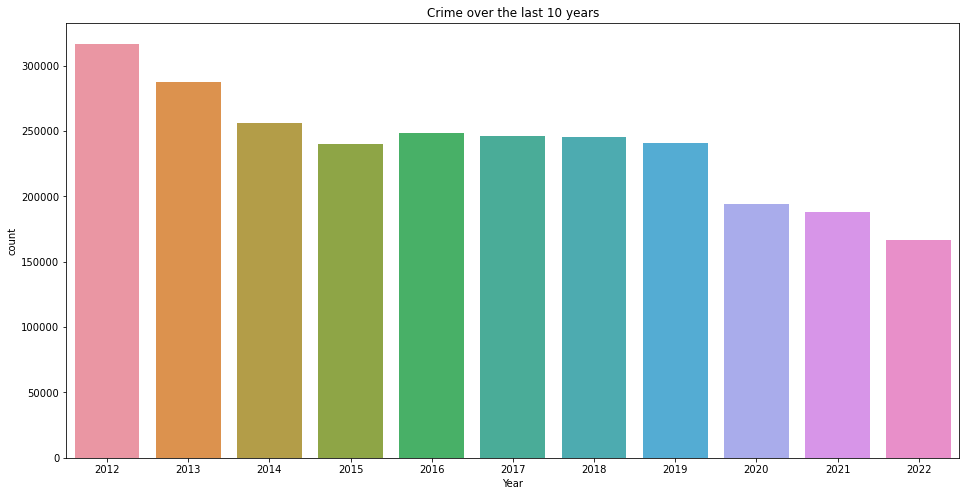

In [233]:
import seaborn as sns
plt.subplots(figsize=(16,8))
sns.barplot(data = year_crime_count_df, x = 'Year', y = 'count').set(title='Crime over the last 10 years')

We can clearly conclude crime in 2012 was highest and may be strict policing helped to reduce it in coming years

#### Find out at which hour of the day crime is highest

In [235]:
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType

In [238]:
from pyspark.sql.functions import date_format
df_pyspark = df_pyspark.withColumn("HourOfDay", date_format("Date_time","H"))

In [239]:
temp = df_pyspark.filter(df_pyspark["Domestic"] == "true")

In [240]:
temp = temp.select(df_pyspark['HourOfDay'].cast('int').alias('HourOfDay'))
hourlyCount  = temp.groupBy(["HourOfDay"]).count().collect()


hours = [item[0] for item in hourlyCount]
count = [item[1] for item in hourlyCount]

crime_byHour = {"count": count, "hours": hours}
crime_byHour = pd.DataFrame(crime_byHour)
crime_byHour = crime_byHour.sort_values(by = "hours", ascending  = True)

22/10/20 21:01:59 ERROR CodeGenerator: failed to compile: org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "processNext()V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1" grows beyond 64 KB
org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "processNext()V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1" grows beyond 64 KB
	at org.codehaus.janino.UnitCompiler.compile2(UnitCompiler.java:366)
	at org.codehaus.janino.UnitCompiler.access$000(UnitCompiler.java:226)
	at org.codehaus.janino.UnitCompiler$1.visitCompilationUnit(UnitCompiler.java:336)
	at org.codehaus.janino.UnitCompiler$1.visitCompilationUnit(UnitCompiler.java:333)
	at org.codehaus.janino.Java$CompilationUnit.accept(Java.java:363)
	at org.codehaus.janino.UnitCompiler.compileUnit(UnitCompiler.java:333)
	

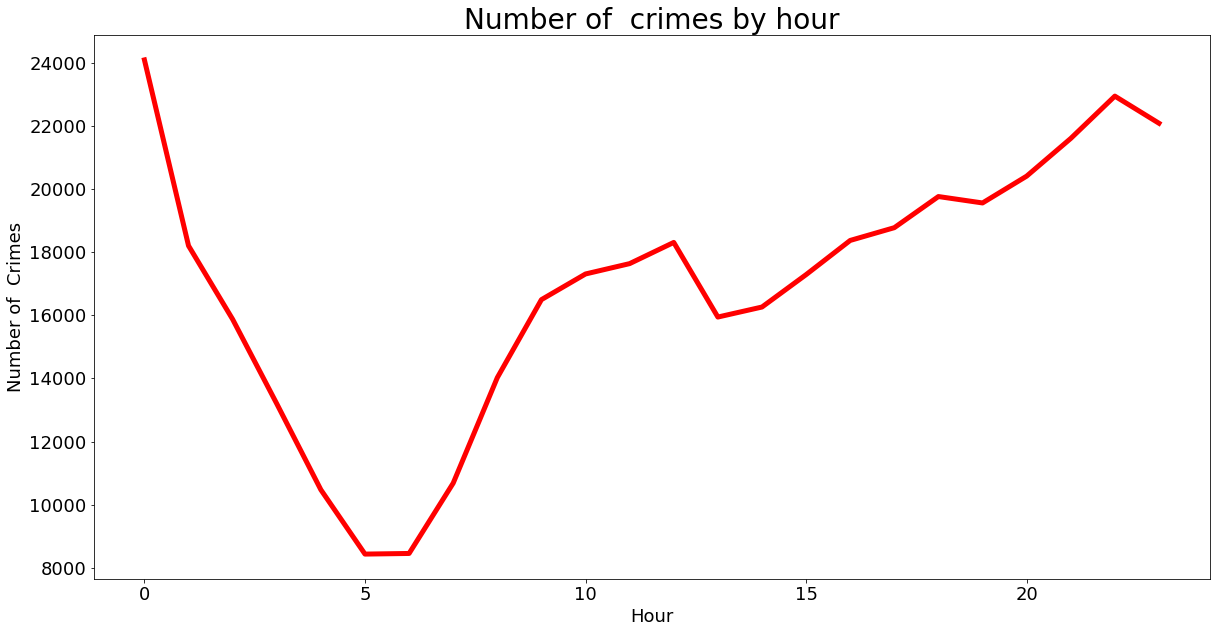

In [244]:
crime_byHour.plot(figsize = (20,10), kind = "line", x = "hours", y = "count", 
                      color = "red", linewidth = 5, legend = False)

plt.ylabel("Number of  Crimes", fontsize = 18)
plt.xlabel("Hour", fontsize = 18)
plt.title("Number of  crimes by hour", fontsize = 28)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()

We can clearly see that crime is highest during mid night around 12.OO AM.

#### Find top ten crimes and present them as a bar chart.

In [143]:
from matplotlib import pyplot as plt

[Text(0.5, 1.0, 'Crime over the last 10 years')]

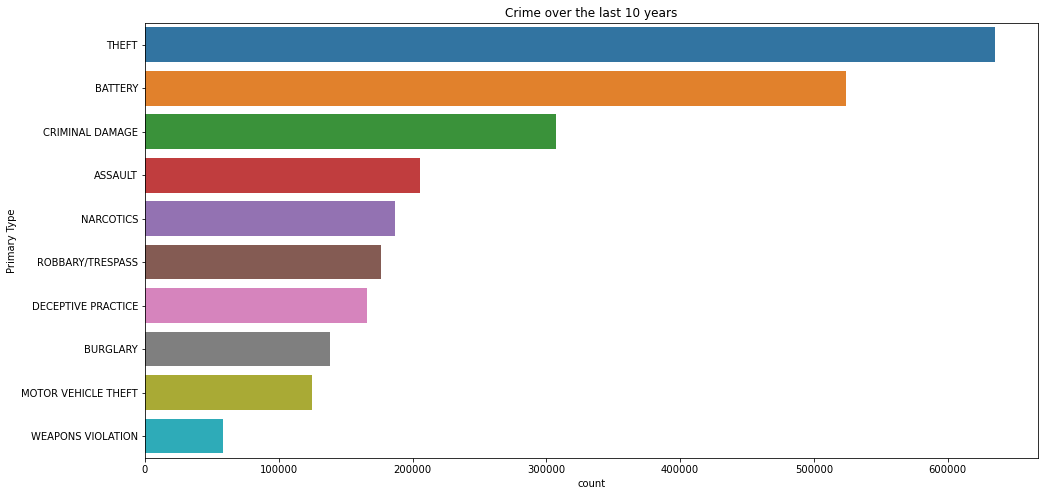

In [99]:
plt.subplots(figsize=(16,8))
sns.barplot(data = type_crime_count_df, x = 'count', y = 'Primary Type').set(title='Crime over the last 10 years')

Theft was the highest committed crime out of all 6 million reported crimes